In [1]:
import numpy as np
from matplotlib import pyplot as plt
import h5py
import glob
import os
import matplotlib.mlab as mlab
from scipy.interpolate import interp1d
from scipy.signal import butter, filtfilt

plt.ion()

os.chdir('LOSC_Event_tutorial/')

def read_template(filename):
    dataFile=h5py.File(filename,'r')
    template=dataFile['template']
    th=template[0]
    tl=template[1]
    return th,tl
def read_file(filename):
    dataFile=h5py.File(filename,'r')
    dqInfo = dataFile['quality']['simple']
    qmask=dqInfo['DQmask'][...]

    meta=dataFile['meta']
    #gpsStart=meta['GPSstart'].value
    gpsStart=meta['GPSstart'][()]
    #print meta.keys()
    #utc=meta['UTCstart'].value
    utc=meta['UTCstart'][()]
    #duration=meta['Duration'].value
    duration=meta['Duration'][()]
    #strain=dataFile['strain']['Strain'].value
    strain=dataFile['strain']['Strain'][()]
    dt=(1.0*duration)/len(strain)

    dataFile.close()
    return strain,dt,utc



#fnames=glob.glob("[HL]-*.hdf5")
#fname=fnames[0]
fnameH1='H-H1_LOSC_4_V2-1128678884-32.hdf5'
fnameL1='L-L1_LOSC_4_V2-1128678884-32.hdf5'
print('reading file ',fnameH1)
print('reading file ',fnameL1)

strain_H1,dt_H1,utc_H1=read_file(fnameH1)
strain_L1,dt_L1,utc_L1=read_file(fnameL1)


#th,tl=read_template('GW150914_4_template.hdf5')
template_name1='LVT151012_4_template.hdf5'
th1,tl1=read_template(template_name1)




#spec,nu=measure_ps(strain,do_win=True,dt=dt,osamp=16)
#strain_white=noise_filter(strain,numpy.sqrt(spec),nu,nu_max=1600.,taper=5000)

#th_white=noise_filter(th,numpy.sqrt(spec),nu,nu_max=1600.,taper=5000)
#tl_white=noise_filter(tl,numpy.sqrt(spec),nu,nu_max=1600.,taper=5000)


#matched_filt_h=numpy.fft.irfft(numpy.fft.rfft(strain_white)*numpy.conj(numpy.fft.rfft(th_white)))
#matched_filt_l=numpy.fft.irfft(numpy.fft.rfft(strain_white)*numpy.conj(numpy.fft.rfft(tl_white)))




#copied from bash from class
# strain2=np.append(strain,np.flipud(strain[1:-1]))
# tobs=len(strain)*dt
# k_true=np.arange(len(myft))*dnu

reading file  H-H1_LOSC_4_V2-1128678884-32.hdf5
reading file  L-L1_LOSC_4_V2-1128678884-32.hdf5


In [2]:
# Let's add a window 
# In the lecture he uses a cosine window which maybe isn't best
# The question suggests using something that has an extended flat period near the center 
# Maybe the tukey window bc it's built into scipy?  

from scipy import signal

def window(n):
    window = signal.windows.tukey(n,0.1)
    return window

n_H1 = len(strain_H1)
win_H1 = window(n_H1)

n_L1 = len(strain_L1)
win_L1 = window(n_L1)



In [3]:
# Now we can account for noise 
# We can start with pre-whitening 
# maybe re-do this with inspo from the ligo function 
# they talk about how the power spectral densities (PSDs) are averages of the square of the fft of the data 

# fs = 4096
# NFFT = 4*fs

# P_H1, freqs = mlab.psd(strain_H1*win_H1,Fs=fs,NFFT=NFFT)
# P_th, freqs = mlab.psd(th1*win_H1,Fs=fs,NFFT=NFFT)

# P_L1, freqs = mlab.psd(strain_L1*win_L1,Fs=fs,NFFT=NFFT)
# P_tl, freqs = mlab.psd(tl1*win_L1,Fs=fs,NFFT=NFFT)


# psd_H1 = interp1d(freqs,P_H1)
# psd_th = interp1d(freqs,P_th)

# psd_L1 = interp1d(freqs,P_L1)
# psd_tl = interp1d(freqs,P_tl)

# # P_smooth = (1.e-22*(18./(0.1+freqs))**2)**2+0.7e-23**2+((freqs/2000.)*4.e-23)**2
# # psd_smooth = interp1d(freqs,P_smooth)

# def whiten(strain,psd,dt):
    
#     N = len(strain)
#     freqs = np.fft.rfftfreq(N,dt)
#     hf = np.fft.rfft(strain)

    
#     Nft = psd(freqs)
    
# A smoothing function inspired from the internet 
#     def smooth(y, box_pts):
#         box = np.ones(box_pts)/box_pts
#         y_smooth = np.convolve(y, box, mode='same')
#         return y_smooth
    
#     Nft = smooth(Nft,50)

# # Jon's smoothing function 
# #     for i in range(10):
# #         Nft=(Nft+np.roll(Nft,1)+np.roll(Nft,-1))/3
    
#     norm = 1./np.sqrt(1./(dt*2))
#     white_hf = hf/ np.sqrt(Nft)*norm
#     white_ht = np.fft.irfft(white_hf,n=N)
#     return white_ht, white_hf, Nft 
    
# strain_H1_white, strain_H1_ft_white, strain_H1_Nft = whiten(strain_H1*win_H1,psd_H1,dt_H1)
# strain_L1_white, strain_L1_ft_white, strain_L1_Nft = whiten(strain_L1*win_L1,psd_L1,dt_L1)


# th_white, th_ft_white, th_Nft = whiten(th1*win_H1,psd_th,dt_H1)
# tl_white, tl_ft_white, tl_Nft = whiten(tl1*win_L1,psd_tl,dt_L1)



In [4]:
# A smoothing function inspired from the internet 
stf_H1 = np.fft.rfft(strain_H1*win_H1)
stf_L1 = np.fft.rfft(strain_L1*win_L1)

Nft_H1 = np.abs(stf_H1)**2
Nft_L1 = np.abs(stf_L1)**2

def smooth(y, box_pts):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth
    
Nft_H1 = smooth(Nft_H1,500)
Nft_L1 = smooth(Nft_L1,500)

strain_ft_H1_white = stf_H1/np.sqrt(Nft_H1)
strain_ft_L1_white = stf_L1/np.sqrt(Nft_L1)

th_ft_white = np.fft.rfft(th1*win_H1)/np.sqrt(Nft_H1)
tl_ft_white = np.fft.rfft(tl1*win_L1)/np.sqrt(Nft_L1)




In [5]:
# # in the LIGO tutorial they do some bandpassing 
# # We can use the fband values from the json file 

# fband0 = 43
# fband1 = 400

# bb, ab = butter(4,[fband0*2./fs, fband1*2./fs], btype='band')
# normalization = np.sqrt((fband1-fband0)/(fs/2))

# strain_H1_ft_white_bp = np.fft.rfft(filtfilt(bb, ab, strain_H1_white)/normalization)
# strain_L1_ft_white_bp = np.fft.rfft(filtfilt(bb, ab, strain_L1_white)/normalization)

# th_ft_white_bp = np.fft.rfft(filtfilt(bb, ab, th_white)/normalization)
# tl_ft_white_bp = np.fft.rfft(filtfilt(bb, ab, tl_white)/normalization)

Text(0.5, 1.0, 'The whitened and smoothed and windowed Fourier strains')

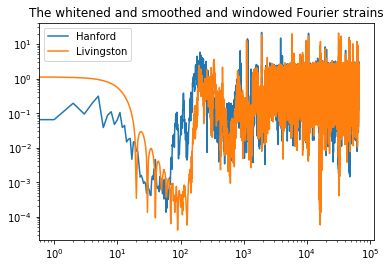

In [6]:
plt.loglog(np.abs(strain_ft_H1_white),label='Hanford')
plt.loglog(np.abs(strain_ft_L1_white),label='Livingston')
plt.legend()
plt.title('The whitened and smoothed and windowed Fourier strains')

Text(0.5, 1.0, 'The smoothed noise!')

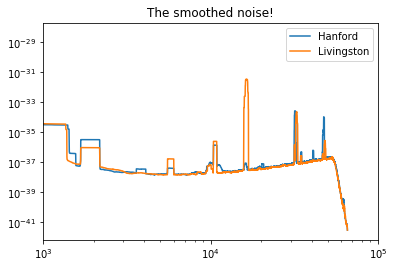

In [7]:
plt.loglog(np.abs(Nft_H1),label='Hanford')
plt.loglog(np.abs(Nft_L1),label='Livingston')
plt.xlim(10**3,10**5)
plt.legend()
plt.title('The smoothed noise!')

Text(0.5, 1.0, 'Hanford Detector')

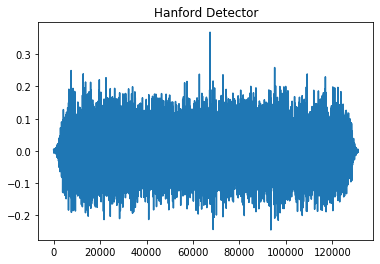

In [8]:
#matched filter 
xcorr_H1 = np.fft.irfft(strain_ft_H1_white*np.conj(th_ft_white))
plt.plot(np.fft.fftshift(xcorr_H1))
plt.title('Hanford Detector')
#plt.xlim(67000,67500)

Text(0.5, 1.0, 'Livingston Detector')

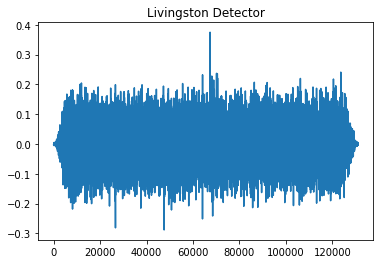

In [9]:
#matched filter 
xcorr_L1 = np.fft.irfft(strain_ft_L1_white*np.conj(tl_ft_white))
plt.plot(np.fft.fftshift(xcorr_L1))
plt.title('Livingston Detector')

#plt.xlim(60000,80000)

In [10]:
# To do C: 

# Estimating the noise ? 
# taking a noise segment from the left of the matched filter 
noise_H1 =np.std(xcorr_H1[20000:60000])/2
print('the noise estimate for the Hanford detector is:', noise_H1)
# taking the amplitude of the spike as the signal
signal_H1 = max(xcorr_H1)
SNR_H1 = signal_H1/noise_H1
print('the SNR for the Hanford detector is:', SNR_H1)


noise_L1 =np.std(xcorr_L1[20000:60000])/2
print('the noise estimate for the Livingston detector is:', noise_L1)
signal_L1 = max(xcorr_L1)
SNR_L1 = signal_L1/noise_L1
print('the SNR for the Livingston detector is:', SNR_L1)
print("---------")
print('Im not sure how to do this for the combined events...')

the noise estimate for the Hanford detector is: 0.030543092564988914
the SNR for the Hanford detector is: 12.048718925151169
the noise estimate for the Livingston detector is: 0.02983643092424871
the SNR for the Livingston detector is: 12.570899000245477
---------
Im not sure how to do this for the combined events...


In [11]:
# To do D: 
# We need to find the analytic signal to noise ratio 
# From the slides, this is apparently SNR^2/mode = (template FT)^2/noisePS
# Where noise PS is the FT of the correlation function 
# I'm confused about the mode part of the expression above 

SNR_H1_A = np.sqrt(np.abs(th_ft_white**2/np.fft.rfft(xcorr_H1)).sum())
print('the analytic SNR for the Hanford detector is:', SNR_H1_A)
SNR_L1_A = np.sqrt(np.abs(tl_ft_white**2/np.fft.rfft(xcorr_L1)).sum())
print('the analytic SNR for the Livingston detector is:', SNR_L1_A)
print('----------------')
print('These values are obviously enormous compared to the ones we get. At face value, it would make sense to me that the actual SNR that we get is lower than what could potentially be achieved. Although, Im a little confused about how this analytic SNR method works, so its also entirely possible that my analytic estimate here is incorrect.')


the analytic SNR for the Hanford detector is: 1069.6590570153924
the analytic SNR for the Livingston detector is: 1043.5421660102404
----------------
These values are obviously enormous compared to the ones we get. At face value, it would make sense to me that the actual SNR that we get is lower than what could potentially be achieved. Although, Im a little confused about how this analytic SNR method works, so its also entirely possible that my analytic estimate here is incorrect.


In [12]:
# To do E 
# We need to 'integrate' over the fourier transform of our cross-correlation

# this takes the sum of the fourier transform of our cross-correlation
# And divides by 2

xcorr_H1_ft = np.abs(np.fft.rfft(xcorr_H1))
half_val_H1 = xcorr_H1_ft.sum()/2
freq_array = np.linspace(0,10**5,len(xcorr_H1))

#Then we loop over the array, summing until we get to half the total, 
#then ask to print the frequency which corresponds 

for i in range(len(freq_array)):
    xcorr_sum = xcorr_H1_ft[:i].sum()
    #print('sum is now:',xcorr_sum)
    if xcorr_sum > half_val_H1:
        print('the frequency value we want for the Hanford detector is (Hz):',freq_array[i])
        break
        
xcorr_L1_ft = np.abs(np.fft.rfft(xcorr_L1))
half_val_L1 = xcorr_L1_ft.sum()/2

for i in range(len(freq_array)):
    xcorr_sum = xcorr_L1_ft[:i].sum()
    #print('sum is now:',xcorr_sum)
    if xcorr_sum > half_val_L1:
        print('the frequency value we want for the Livingston detector is (Hz):',freq_array[i])
        break
    
    

the frequency value we want for the Hanford detector is (Hz): 3550.74730489582
the frequency value we want for the Livingston detector is (Hz): 3456.1420909278177


for the Hanford detector, it seems like the time of arrival is 16.435s!


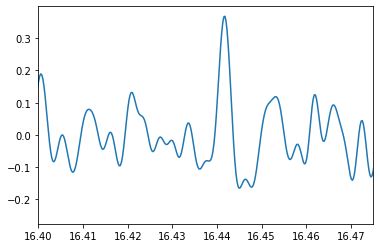

In [13]:
# To do F, we can convert the x axis of our matched filter result 
# to be in seconds 
# Then we can zoom in to see when the signal pops up 
# We know that for each event they took data for 32 seconds 

time_H1 = np.linspace(0,32,len(xcorr_H1))
plt.plot(time_H1,np.fft.fftshift(xcorr_H1))
plt.xlim(16.4,16.475)

print('for the Hanford detector, it seems like the time of arrival is 16.435s!')

for the Hanford detector, it seems like the time of arrival is 16.44s!


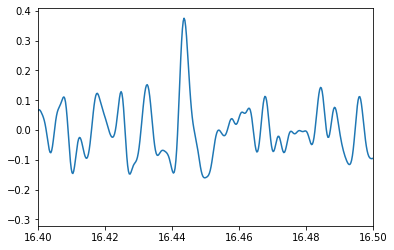

In [14]:
time_L1 = np.linspace(0,32,len(xcorr_L1))
plt.plot(time_L1,np.fft.fftshift(xcorr_L1))
plt.xlim(16.4,16.5)

print('for the Hanford detector, it seems like the time of arrival is 16.44s!')